# Understanding cloud organization with MaskRCNN using Keras/Tensorflow

This kernel is a first attempt to use a MaskRCNN to solve the cloud organization classification problem. It also helps to evaluate how promising the results are within the allowed processing time on kernels as it is likely such model will take much longer to train properly. It is using the [Matterplot implementation of MaskRCNN](https://github.com/matterport/Mask_RCNN) and is inspired from [this kernel](https://www.kaggle.com/pednoi/training-mask-r-cnn-to-be-a-fashionista-lb-0-07) from the iMaterialist competition. If you are particularly interested in data cleaning for a MaskRCNN, I have also created [another kernel](https://www.kaggle.com/frlemarchand/keras-maskrcnn-kuzushiji-recognition) for the Kuzushiji recognition competition which may be of help.

### If you find this kernel useful, please give an upvote! :)

In [3]:
import os
import gc
import sys
import time
import json
import glob
import random

In [4]:
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

In [5]:
import itertools
from tqdm import tqdm
from pathlib import Path
import pandas as pd

In [6]:
# reading the training data set csv file and dropping the na values 
train_df = pd.read_csv("../input/understanding_cloud_organization/train.csv")
train_df = train_df.dropna()

In [7]:
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


The following cells are simply to arrange the data in such format so that it can be fed to the MaskRCNN. For each image, we can a list of masks in RLE (the "EncodedPixels" column) and the corresponding cloud category ("CategoryId")

In [8]:
# defining the categories of clouds
category_list = ["Fish","Flower","Gravel","Sugar"]

In [9]:
training_dict = {}
training_class_dict = {}
for ids, row in train_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    class_name = row.Image_Label.split("_")[1]
    class_id = category_list.index(class_name)
    if training_dict.get(image_filename):
        training_dict[image_filename].append(row.EncodedPixels)
        training_class_dict[image_filename].append(class_id)
    else:
        training_dict[image_filename] = [row.EncodedPixels]
        training_class_dict[image_filename] = [class_id]

In [10]:
data = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
for key, value in training_dict.items():
    image = Image.open("../input/understanding_cloud_organization/train_images/{}".format(key))
    width, height = image.width, image.height
    data = data.append({"image_id": key, "EncodedPixels": value, "CategoryId": training_class_dict[key], "Width": width, "Height": height},ignore_index=True)

In [11]:
data.head()

,image_id,EncodedPixels,CategoryId,Width,Height
0,0011165.jpg,[264918 937 266318 937 267718 937 269118 937 2...,"[0, 1]",2100,1400
1,002be4f.jpg,[233813 878 235213 878 236613 878 238010 881 2...,"[0, 1, 3]",2100,1400
2,0031ae9.jpg,[3510 690 4910 690 6310 690 7710 690 9110 690 ...,"[0, 1, 3]",2100,1400
3,0035239.jpg,[100812 462 102212 462 103612 462 105012 462 1...,"[1, 2]",2100,1400
4,003994e.jpg,[2367966 18 2367985 2 2367993 8 2368002 62 236...,"[0, 2, 3]",2100,1400


# Setting the MaskRCNN

In [12]:
DATA_DIR = Path('../kaggle/input/')
ROOT_DIR = "../../working"

NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [13]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 47.93 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [14]:
#making the directory for the MAsk_RCNN model
sys.path.append(ROOT_DIR+'/Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We will use the COCO weights for the MaskRCNN as a base, even though the images are from a different domain than our satellite images.

In [15]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Aug 16 17:40 mask_rcnn_coco.h5


In [16]:
#./Mask_RCNN/mask_rcnn_coco.h5

In [17]:
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 
    
    BACKBONE = 'resnet101' # running with the resnet 101 as backbone
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [18]:
#resizing the images to be fed to the Mask_RCNN Model
def resize_image(image_path):
    images = cv2.imread(image_path)
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    images = cv2.resize(images, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return images

In [19]:
class Clouddataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("cloud", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("cloud", 
                           image_id=row.name, 
                           path='../../input/understanding_cloud_organization/train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

We define that 90% of the data will be used for training and 10% left for validation, before displaying some examples of masks.

('../../input/understanding_cloud_organization/train_images/392a36c.jpg', ['Gravel', 'Sugar'])


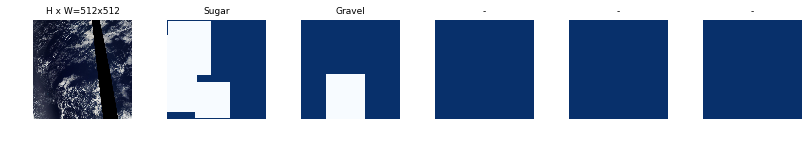

('../../input/understanding_cloud_organization/train_images/7b396e6.jpg', ['Flower'])


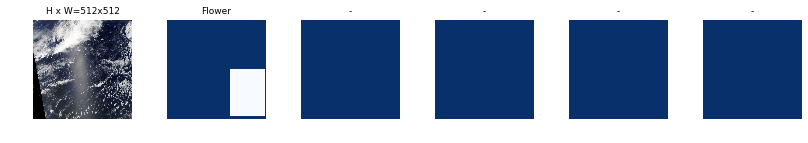

('../../input/understanding_cloud_organization/train_images/94eeec2.jpg', ['Fish', 'Flower', 'Gravel', 'Sugar'])


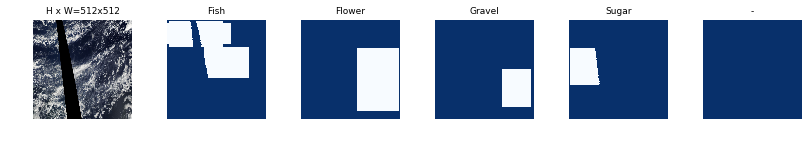

('../../input/understanding_cloud_organization/train_images/894d71e.jpg', ['Flower'])


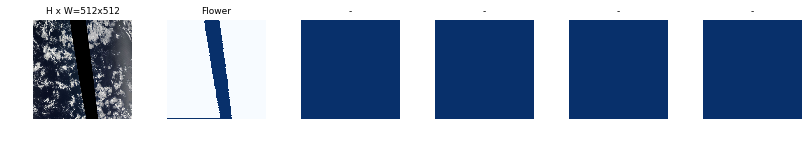

('../../input/understanding_cloud_organization/train_images/0ac087b.jpg', ['Gravel', 'Sugar'])


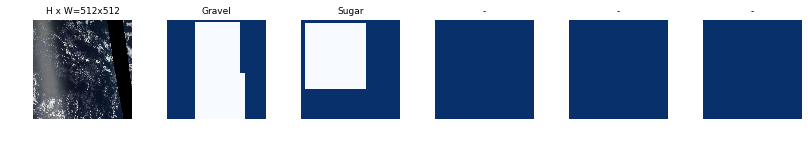

In [20]:
# Training dataset 
train_frac = 0.9

train_size = int(train_frac*len(data))
valid_size = int((1-train_frac)*len(data))

train_data = Clouddataset(data[:train_size])
train_data.prepare()
# # Validation Dataset
valid_data = Clouddataset(data[train_size:train_size+valid_size])
valid_data.prepare()
#  displaying some images  from the training dataset
for i in range(5):
    image_id = random.choice(train_data.image_ids)
    print(train_data.image_reference(image_id))
#    
    image = train_data.load_image(image_id)
    mask, class_ids = train_data.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_data.class_names, limit=5)

# Start training

Let's hope that this 8 epochs will run within the 9 hours allowed.

In [21]:
lr = 1e-4  
epochs = [1,7]

import warnings 
warnings.filterwarnings("ignore")
#epochs

Augmentation is quite important in our case as it turns out a few samples had contrast issues and differentiating between the 4 types of clouds is no easy feat. We proceed to flip the image both vertically and horizontally, before applying different techniques to crop and alter the colours.

In [22]:
#doing some augumentation
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

We initialize the model with the COCO weights even though they are quite different from the satellite imagery in the dataset provided.

In [23]:
MODEL_DIR = os.path.join(ROOT_DIR) # making a new model directory 
#MODEL_DIR
# working with coco weights
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 
                                                             'mrcnn_bbox', 'mrcnn_mask'])
    

In [24]:
#MODEL_DIR

We will first train the heads before training the entire model.

In [25]:
# this code is for training a head layers 
#%%time
#model.train(train_data, valid_data,
#            learning_rate=lr*2,
#            epochs=epochs[0], # meaning the value of epoch is 3 
#            layers='heads',
#            augmentation=None)
#
#history = model.keras_model.history.history

 resnet 101 backbone, Epochs = 9, learning rate = 0.0001, initialized with coco weights

In [26]:
%%time
model.train(train_data, valid_data,
            learning_rate=lr*2,
            epochs=epochs[1],
            layers='all',
            augmentation=augmentation)


#for k in new_history: history[k] = history[k] + new_history[k]
#model_path


Starting at epoch 0. LR=0.0002

Checkpoint Path: ../../working/cloud20211204T0710/mask_rcnn_cloud_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Process ForkPoolWorker-3:
KeyboardInterrupt
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.

KeyboardInterrupt: 

Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._ar

In [29]:
#model_path = os.path.join(MODEL_DIR)
#model.keras_model.save_weights(model_path)


history = model.keras_model.history.history

In [30]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  5
Valid loss:  1.7072002909183501


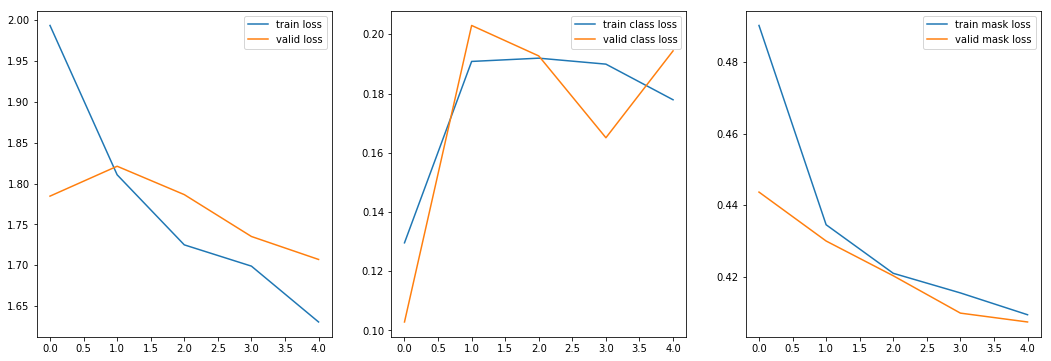

In [38]:
#plotting the losses
epoch_new = [1,5]
EP = range(epoch_new[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(EP, history['loss'], label="train loss")
plt.plot(EP, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(EP, history['mrcnn_class_loss'], label="train class loss")
plt.plot(EP, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(EP, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(EP, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

# Load the best weights and visual assessment on small sample

In [192]:
class InferenceConfig(CloudConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)


original_image           shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int64
gt_bbox                  shape: (2, 4)                min:    2.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  uint8


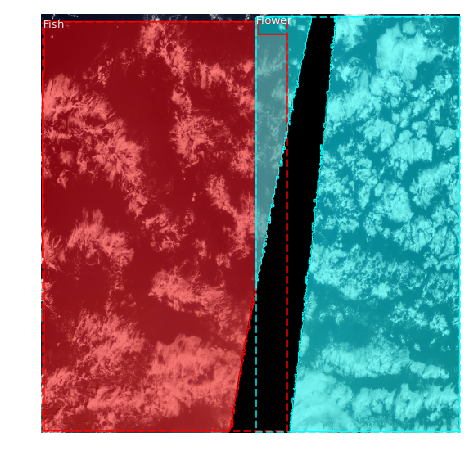

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


In [206]:
# Test on a random image
image_id = random.choice(valid_data.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_data, inference_config, 
                           image_id, use_mini_mask=False)
info = valid_data.image_info[image_id]


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_data.class_names, figsize=(8, 8))
results = model.detect([original_image], verbose=1)
r = results[0]

#ax = get_ax(1)
r = results[0]

In [210]:
glob_list = glob.glob(f'../../working/cloud*/mask_rcnn_cloud_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

Re-starting from epoch 5


In [211]:
# Fix overlapping masks
def fix_overlap_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_ind = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_ind:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_post = np.where(masks[:, :, m]==True)
        if np.any(mask_post):
            y1, x1 = np.min(mask_post, axis=1)
            y2, x2 = np.max(mask_post, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [212]:
#! ls
sample_data = pd.read_csv("../../input/understanding_cloud_organization/sample_submission.csv")
sample_data.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,1 1
1,002f507.jpg_Flower,1 1
2,002f507.jpg_Gravel,1 1
3,002f507.jpg_Sugar,1 1
4,0035ae9.jpg_Fish,1 1


In [213]:
test_data = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_data.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_data = test_data.append({"image_id": image_filename},ignore_index=True)
test_data = test_data.drop_duplicates()

In [214]:
test_data.head()

,image_id,EncodedPixels,CategoryId
0,002f507.jpg,NaN,NaN
4,0035ae9.jpg,NaN,NaN
8,0038327.jpg,NaN,NaN
12,004f759.jpg,NaN,NaN
16,005ba08.jpg,NaN,NaN


../../input/understanding_cloud_organization/test_images/4b990b9.jpg


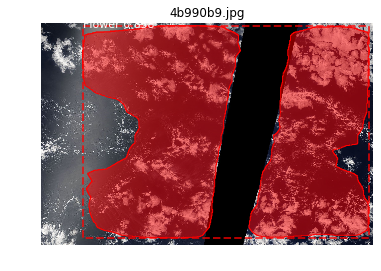

../../input/understanding_cloud_organization/test_images/09c806e.jpg


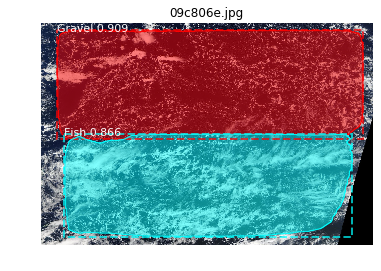

../../input/understanding_cloud_organization/test_images/3e4c725.jpg


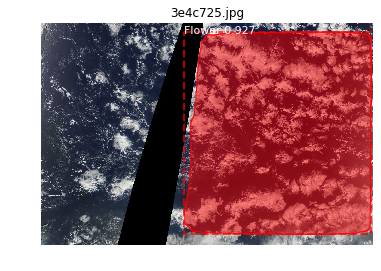

../../input/understanding_cloud_organization/test_images/665caf9.jpg


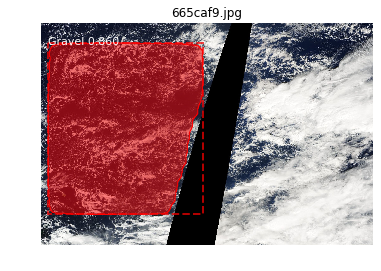

../../input/understanding_cloud_organization/test_images/60853e7.jpg

*** No instances to display *** 



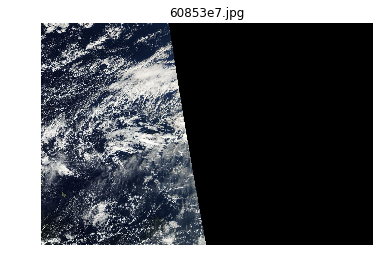

../../input/understanding_cloud_organization/test_images/52b8e4f.jpg

*** No instances to display *** 



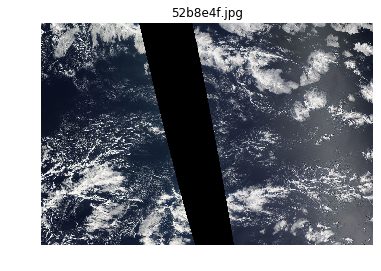

../../input/understanding_cloud_organization/test_images/db52932.jpg

*** No instances to display *** 



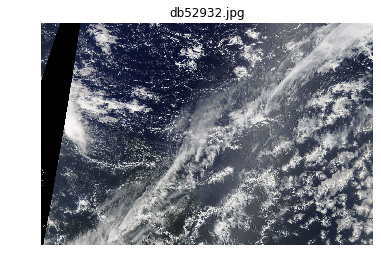

../../input/understanding_cloud_organization/test_images/7c0f610.jpg

*** No instances to display *** 



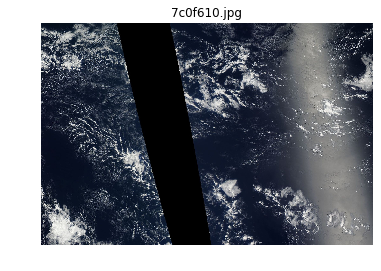

../../input/understanding_cloud_organization/test_images/05af734.jpg


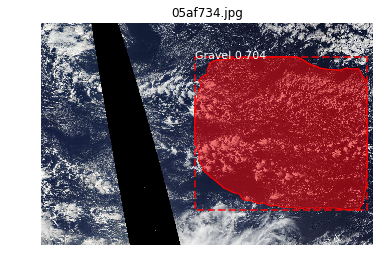

../../input/understanding_cloud_organization/test_images/00db8b3.jpg


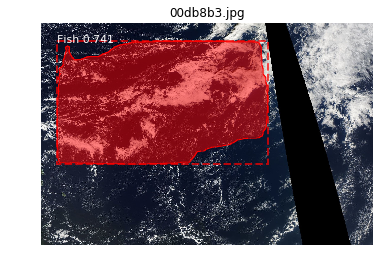

In [215]:
for i in range(10):
    image_id = test_data.sample()["image_id"].values[0]
    image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = fix_overlap_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(6, 6))
    

    

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    4.00000  int64
gt_bbox                  shape: (3, 4)                min:    1.00000  max:  503.00000  int32
gt_mask                  shape: (512, 512, 3)         min:    0.00000  max:    1.00000  uint8
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
original_image           shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
image_meta               shape: (17,

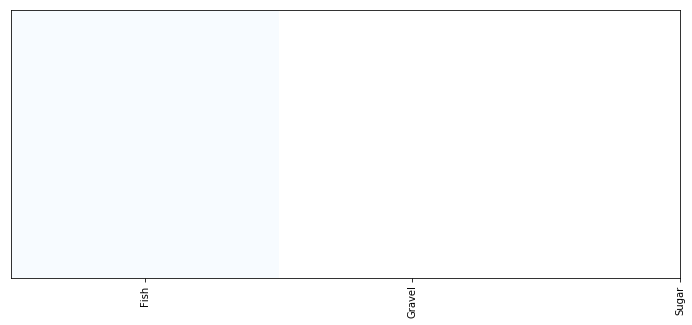

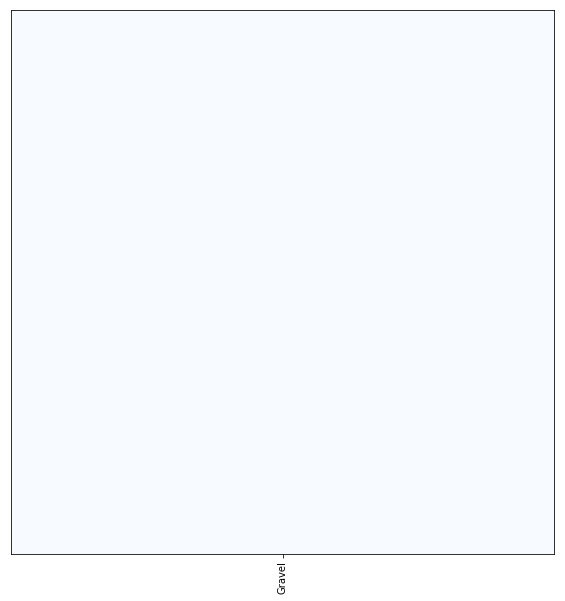

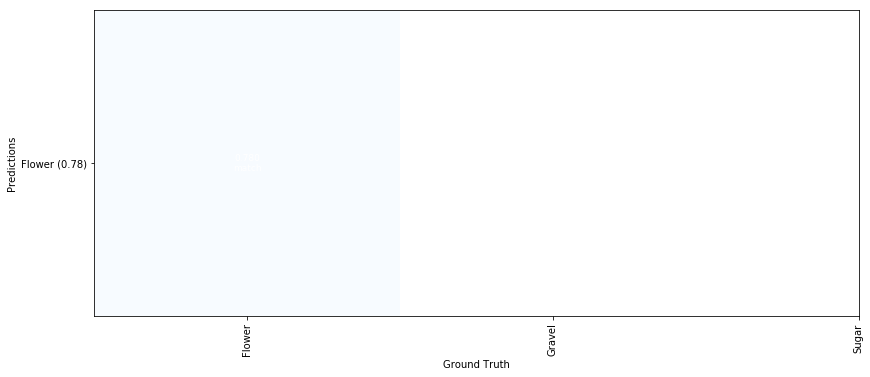

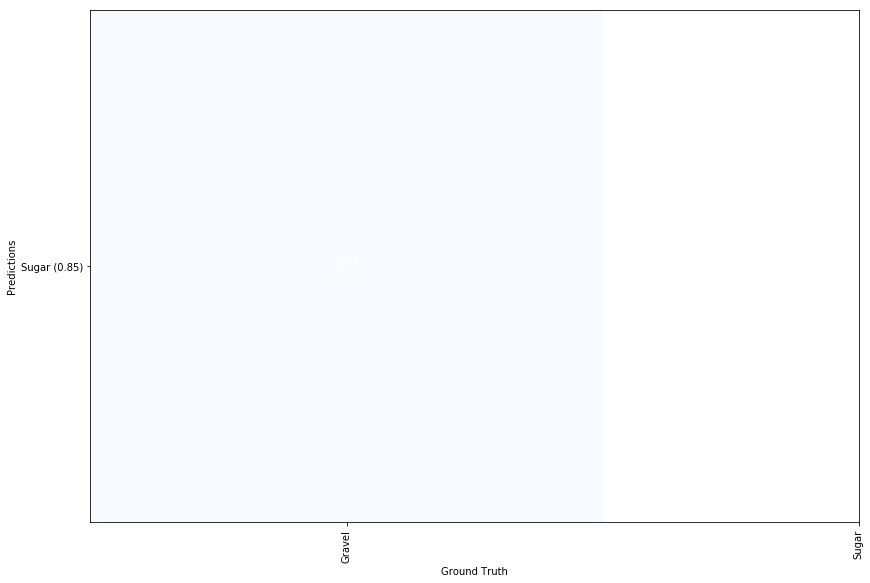

In [241]:
# Test on a random image
for i in range(4):
    image_id = random.choice(valid_data.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(valid_data, inference_config, 
                               image_id, use_mini_mask=False)
    #info = valid_data.image_info[image_id]
    
    
    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
   
    #visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
     #                           valid_data.class_names, figsize=(8, 8))
    results = model.detect([original_image], verbose=1)
    
    r = results[0]
    try:
        visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],overlaps, valid_data.class_names)

    except:
        IndexError
  



In [101]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(valid_data.image_ids, 5)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(valid_data, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs), "recall:" , np.mean(recalls))

mAP:  0.6 recall: 0.6666666666666666


In [110]:
print("mAP: ", np.mean(APs), "recall:" , np.mean(recalls), "precision=",  np.mean(precisions))

mAP:  0.6 recall: 0.6666666666666666 precision= 0.6666666666666666


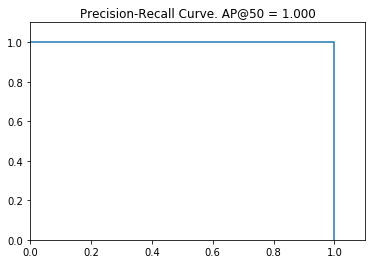

In [123]:
# Draw precision-recall curve
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)